In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [90]:
path = "data/train.csv"
df = pd.read_csv(path)
df.drop(df.columns[[2, 3]], inplace=True, axis=1)
columns  = ["timestamp", "hourly_traffic_count"]
df.columns = columns
df.head(5)


,timestamp,hourly_traffic_count
0,04/01/2016 0:00,12
1,04/01/2016 0:05,13
2,04/01/2016 0:10,11
3,04/01/2016 0:15,13
4,04/01/2016 0:20,10


In [91]:
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
df['weekday'] = df['timestamp'].dt.weekday

# Feature engineering with the date
df['year']= df['timestamp'].dt.year 
df['month']= df['timestamp'].dt.month 
df['day']= df['timestamp'].dt.day

df.head(3)

original_df = df.copy()

In [92]:
df['weekday_num'] = df['weekday']
df['weekday'].replace(0,'01 - Monday',inplace=True)
df['weekday'].replace(1,'02 - Tuesday',inplace=True)
df['weekday'].replace(2,'03 - Wednesday',inplace=True)
df['weekday'].replace(3,'04 - Thursday',inplace=True)
df['weekday'].replace(4,'05 - Friday',inplace=True)
df['weekday'].replace(5,'06 - Saturday',inplace=True)
df['weekday'].replace(6,'07 - Sunday',inplace=True)

df.head()

,timestamp,hourly_traffic_count,weekday,year,month,day,weekday_num
0,2016-04-01 00:00:00,12,05 - Friday,2016,4,1,4
1,2016-04-01 00:05:00,13,05 - Friday,2016,4,1,4
2,2016-04-01 00:10:00,11,05 - Friday,2016,4,1,4
3,2016-04-01 00:15:00,13,05 - Friday,2016,4,1,4
4,2016-04-01 00:20:00,10,05 - Friday,2016,4,1,4


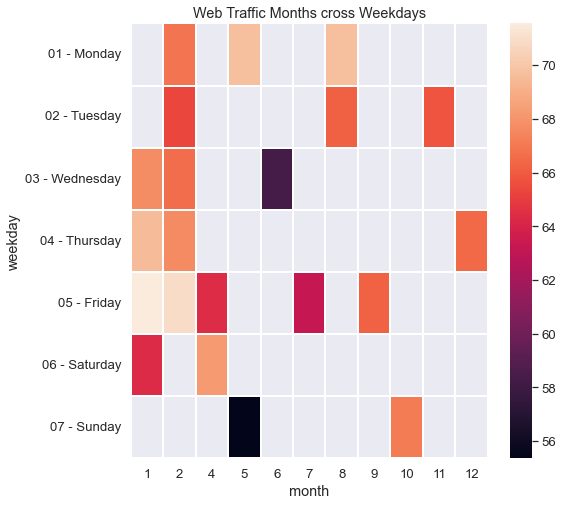

In [93]:
train_group = df.groupby(["month", "weekday"])['hourly_traffic_count'].mean().reset_index()
train_group = train_group.pivot('weekday','month','hourly_traffic_count')
train_group.sort_index(inplace=True)

import seaborn as sns
sns.set(font_scale=1.2) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()


In [94]:
mean_group = df[['timestamp','hourly_traffic_count']].groupby(['timestamp'])['hourly_traffic_count'].mean()

times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['timestamp'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['timestamp'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
del times_series_means['timestamp']
times_series_means.head()

,hourly_traffic_count,weekday,year,month,day
0,15.0,5,2016,01,02
1,7.0,5,2016,01,02
2,11.0,5,2016,01,02
3,7.0,5,2016,01,02
4,9.0,5,2016,01,02


In [95]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler

In [97]:
X, y = times_series_means.drop(['hourly_traffic_count','year'],axis=1), times_series_means['hourly_traffic_count']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)

trainx, testx, trainy, testy = train_test_split(scaled, y, test_size=0.2)

model = Sequential()
model.add(LSTM(50, input_shape=(3,1)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(trainx, trainy, epochs=50, batch_size=8, validation_data=(testx, testy), verbose=2, shuffle=False)

Epoch 1/50
778/778 - 4s - loss: 48.0658 - val_loss: 40.5569 - 4s/epoch - 5ms/step
Epoch 2/50
778/778 - 1s - loss: 37.2463 - val_loss: 35.2169 - 1s/epoch - 2ms/step
Epoch 3/50
778/778 - 1s - loss: 34.8887 - val_loss: 34.3447 - 1s/epoch - 2ms/step
Epoch 4/50
778/778 - 2s - loss: 34.6232 - val_loss: 34.3022 - 2s/epoch - 2ms/step
Epoch 5/50
778/778 - 2s - loss: 34.6150 - val_loss: 34.2983 - 2s/epoch - 2ms/step
Epoch 6/50
778/778 - 1s - loss: 34.6144 - val_loss: 34.2972 - 1s/epoch - 2ms/step
Epoch 7/50
778/778 - 1s - loss: 34.6143 - val_loss: 34.2969 - 1s/epoch - 2ms/step
Epoch 8/50
778/778 - 2s - loss: 34.6143 - val_loss: 34.2965 - 2s/epoch - 2ms/step
Epoch 9/50
778/778 - 2s - loss: 34.6141 - val_loss: 34.2961 - 2s/epoch - 2ms/step
Epoch 10/50
778/778 - 1s - loss: 34.6140 - val_loss: 34.2957 - 1s/epoch - 2ms/step
Epoch 11/50
778/778 - 1s - loss: 34.6138 - val_loss: 34.2953 - 1s/epoch - 2ms/step
Epoch 12/50
778/778 - 1s - loss: 34.6140 - val_loss: 34.2944 - 1s/epoch - 2ms/step
Epoch 13/50
7

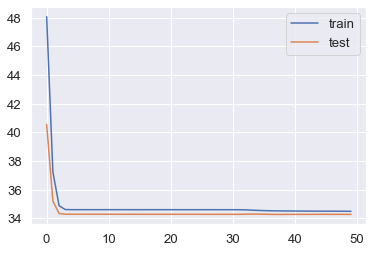

Test RMSE: 41.711


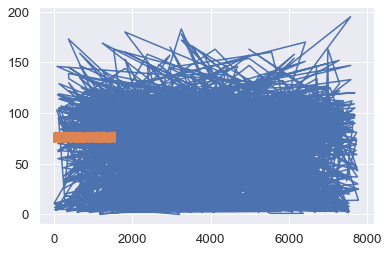

In [100]:
from sklearn.metrics import mean_squared_error

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(testx).reshape(1, -1)[0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.3f' % rmse)

plt.figure()
plt.plot(testy, label='Actual')
plt.plot(yhat, label='Predicted')

plt.show()